## Trailing losses ##

Trailing losses occur for moving objects when their motion during an exposure (or visit) makes them cover an area larger than the PSF. 

Note that for LSST, each visit is composed of 2 shorter exposures. The pair is used to reject cosmic rays, but will be simply added together for a single visit limiting magnitude equivalent to the combination of the two visits (LSST is sky-noise limited in all bands except u band, which also has a non-negligble read-noise contribution). The spacing between the two exposures is nominally 2 seconds (the readout time), however the shutter requires 1 second to move across the field of view. The shutter is composed of two blades which travel across the fov one after another (e.g. one blade 'opens' the camera, the second blade 'closes' it; for the next exposure, the second blade 'opens', followed by the first blade 'closing' the camera and returning to the starting positions). Thus, the midpoint of any particular exposure varies by 1 second across the fov but the total exposure time is constant. The 'gap' between a pair of exposures in a visit varies from 2 seconds to 4 seconds, depending on location in the fov relative to the shutter movement. 

If the shutter is opening L-R then R-L, then a point on the L side of the camera will have an exposure midpoint 1 second earlier than a point on the R side of the camera, will have a 4 second gap between exposures instead of a 2 second gap, and have the midpoint of the second exposure 1 second later than the R side of the camera. This may complicate trailing calculations. 

Each object will have the same trail length in the individual exposures, and the same overall 'central' location, but slightly different combined trail length due to variation in length of gap in middle of the visit. 

---
Simple example of motion (just to show gap between exposures in a single visit).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

0.354166666667 0.354166666667


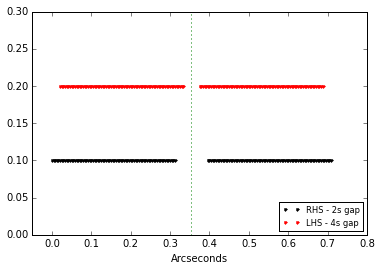

In [13]:
velocity = 0.5 #deg/day
velocity = velocity /24.0 #arcseconds/second
exposuretime = np.arange(0, 15.01, 0.2) #seconds
timesL = np.concatenate([exposuretime, exposuretime+exposuretime.max()+4])
timesR = np.concatenate([exposuretime+1., exposuretime+exposuretime.max()+2.+1])
#print timesL.mean(), timesL.min(), timesL.max()
#print timesR.mean(), timesR.min(), timesR.max()
positionL = velocity * timesL
positionR = velocity * timesR
plt.figure()
plt.plot(positionL, np.zeros(len(positionL))+0.1, 'k.', label='RHS - 2s gap')
plt.plot(positionR, np.zeros(len(positionR))+0.2, 'r.', label='LHS - 4s gap')
plt.ylim(0, 0.3)
plt.xlim(-0.05, None)
plt.xlabel('Arcseconds')
plt.legend(loc='lower right', fontsize='smaller')
plt.axvline(positionL.mean(), color='g', linestyle=':')
print positionL.mean(), positionR.mean()

---
#PSF#

Now let's add in the seeing distribution, to look at the flux profile of the sources. 

Assume the PSF (for a stationary source) is consistent with Kolmogorov turbulence (see section 4.4 of the [SNR doc](http://ls.st/lse-40)). For moving objects, we can create many 'stationary' PSFs, at a series of locations along the trail of the object.

A good description of the PSF is a double-gaussian:
\begin{equation}
p_K(r | \alpha) \, =  \, 0.909 \left( p(r | \alpha) + 0.1 p(r | 2\alpha) \right) \\
p(r | \alpha) \, = \frac{1}{2 \pi \alpha^2} exp( \frac{-r^2}{2 \alpha^2})
\end{equation}

This influences $n_{eff}$ when calculating the number of pixels for SNR as well. 
\begin{equation}
n_{eff} = \sum_i \frac{1}{p_i} \\
n_{eff} = 2.436 \, (FWHM / pixelscale)^2
\end{equation}

In [63]:
def stationaryPSF(seeing, totalflux=1, xcen=0, ycen=0):
    "Distribute flux across PSF. seeing in arcseconds"
    # Translate 'seeing' FWHM to gaussian 'sigma' (alpha in the equations above)
    alpha = seeing / 2.355
    stepsize = 0.01
    maxrad = alpha*10.0
    x = np.arange(0, 2*maxrad, stepsize) 
    x = x - x.mean() + xcen
    y = np.arange(0, 2*maxrad, stepsize)
    y = y - y.mean() + ycen
    xi, yi = np.meshgrid(x, y)
    radius = np.sqrt((xi-xcen)**2 + (yi-ycen)**2)
    p1 = 1.0/2.0/np.pi/alpha**2 * np.exp(-radius**2/2.0/alpha**2)
    p2 = 1.0/2.0/np.pi/(alpha*2)**2 * np.exp(-radius**2/2.0/(2*alpha)**2)
    p = 0.909*(p1 + 0.1*p2)
    flux = p * totalflux
    # Flux = flux[y][x], although here it doesn't matter because len(x) = len(y)
    return x, y, flux

In [64]:
from scipy import interpolate 

def zoomImage(x, y, flux, zoom=[-1, 1, -1, 1], zmax=1.6):
    """Zoom in and show the image in region 'zoom'."""
    nbins = 200.0
    binsize = (zoom[1]-zoom[0])/nbins
    xg = np.arange(zoom[0], zoom[1]+binsize, binsize)
    binsize = (zoom[3] - zoom[2])/nbins
    yg = np.arange(zoom[2], zoom[3]+binsize, binsize)
    xgrid, ygrid = np.meshgrid(xg, yg)
    showflux = interpolate.interpn((y, x), flux, (ygrid, xgrid), 
                                   method='splinef2d', bounds_error=False, fill_value=0)
    plt.imshow(showflux, extent=zoom, vmin=0, vmax=zmax, origin='lower')
    plt.colorbar()

In [100]:
def crossSection(x, y, flux, xi=None, yi=None):
    """Take a cross-section at xi/yi and return the flux values."""
    if xi is None:
        xi = np.mean(x)
    if yi is None:
        yi = np.mean(y)
    # Find closest point in x/y arrays.
    xindx = np.argmin(np.abs(x-xi))
    yindx = np.argmin(np.abs(y-yi))
    fluxx = flux[yindx][:]
    fluxy = np.swapaxes(flux, 0, 1)[xindx][:]
    return fluxx, fluxy

Check these tools out with stationary PSF.

(-2, 2)

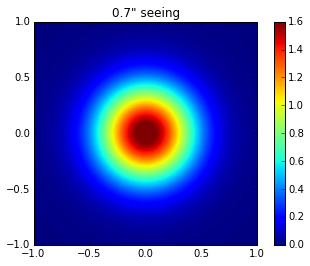

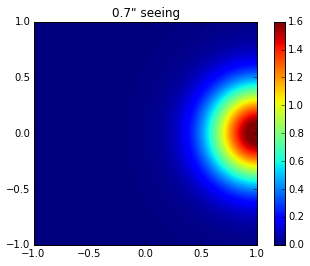

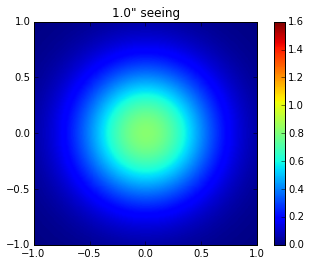

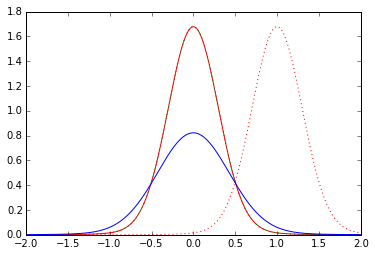

In [101]:
x, y, flux = stationaryPSF(0.7)
plt.figure()
zoomImage(x, y, flux)
plt.title('0.7" seeing')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
x1 = x
fx1 = fluxx

x, y, flux = stationaryPSF(0.7, xcen=1)
plt.figure()
zoomImage(x, y, flux)
plt.title('0.7" seeing')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux, xi=1)
x2 = x
fx2 = fluxx
y2 = y
fy2 = fluxy

x, y, flux = stationaryPSF(1.0)
plt.figure()
zoomImage(x, y, flux)
plt.title('1.0" seeing')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
plt.plot(x1, fx1, 'r')
plt.plot(x2, fx2, 'r:')
plt.plot(y2, fy2, 'g:')
plt.plot(x, fluxx, 'b')
plt.xlim(-2, 2)

#Moving object PSF#

Now simulate a moving object as a series of stationary PSFs, summing all the flux vlaues contributed by each stationary PSF.

In [114]:
def movingPSF(velocity=1.0, seeing=0.7, totalflux=1.0, side='L'):
    "Simulate a moving object;  velocity (deg/day), seeing(arcsecond), side='L' or 'R' (L=4sec gap)"""
    velocity = velocity / 24.0 #arcsecond/second
    exposureTimeSteps = seeing/velocity/20.0
    exposuretime = np.arange(0, 15+exposureTimeSteps/2.0, exposureTimeSteps) #seconds
    timesL = np.concatenate([exposuretime, exposuretime+exposuretime.max()+4])
    timesR = np.concatenate([exposuretime+1., exposuretime+exposuretime.max()+2.+1])
    positionL = velocity * timesL
    positionR = velocity * timesR
    xlist = []
    ylist = []
    fluxlist = []
    if side=='L':
        positions = positionL
    else:
        positions = positionR
    for p in (positions):
        xcen = p
        x, y, flux = stationaryPSF(0.7, xcen=xcen, ycen=0)
        xlist.append(x)
        ylist.append(y)
        fluxlist.append(flux)

    xmin = np.array([x.min() for x in xlist]).min()
    xmax = np.array([x.max() for x in xlist]).max()
    ymin = np.array([y.min() for y in ylist]).min()
    ymax = np.array([y.max() for y in ylist]).max()
    stepsize = 0.01 #arcseconds
    x = np.arange(xmin, xmax+stepsize, stepsize)
    y = np.arange(ymin, ymax+stepsize, stepsize)
    xgrid, ygrid = np.meshgrid(x, y)
    flux = np.zeros(np.shape(xgrid), float)
    for xi, yi, fi in zip(xlist, ylist, fluxlist):
        f = interpolate.interpn((yi, xi), fi, (ygrid, xgrid), bounds_error=False, fill_value=0)
        flux += f
    flux = flux / flux.sum() * totalflux
    return x, y, flux

In [120]:
velocity = 1.0 #deg/day
seeing = 0.7 #arcseconds
x, y, flux = movingPSF(velocity=velocity, seeing=seeing, totalflux=5e6)

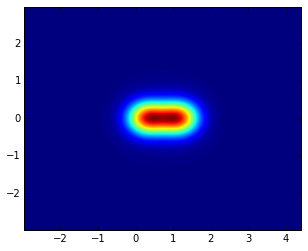

In [121]:
plt.imshow(flux, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])

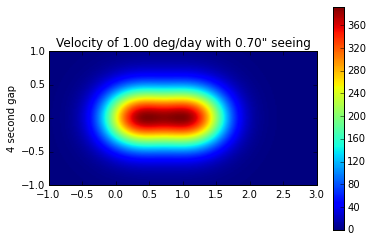

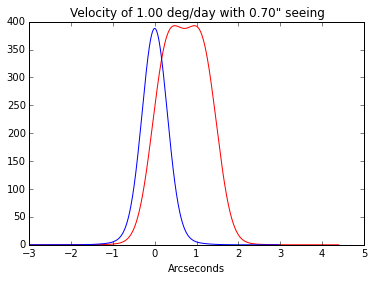

In [122]:
zoomImage(x, y, flux, zoom=[-1, 3, -1, 1], zmax=flux.max())
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))
plt.ylabel('4 second gap')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)
plt.figure()
plt.plot(x, fluxx, 'r', label='Lengthwise')
plt.plot(y, fluxy, 'b', label='Crossection')
plt.xlabel('Arcseconds')
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))

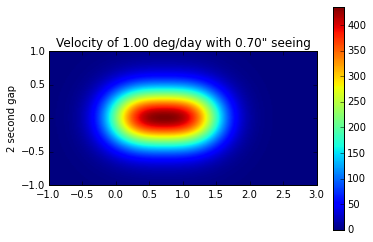

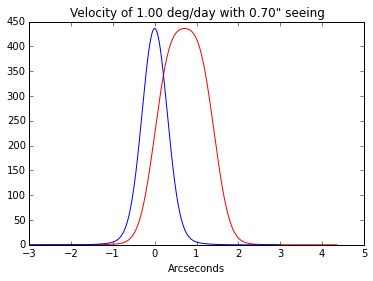

In [124]:
x, y, flux = movingPSF(side='R', velocity=velocity, seeing=seeing, totalflux=5e6)
zoomImage(x, y, flux, zoom=[-1, 3, -1, 1], zmax=flux.max())
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))
plt.ylabel('2 second gap')
plt.figure()
fluxx, fluxy = crossSection(x, y, flux)

plt.figure()
plt.plot(x, fluxx, 'r', label='Lengthwise')
plt.plot(y, fluxy, 'b', label='Crossection')
plt.xlabel('Arcseconds')
plt.title('Velocity of %.2f deg/day with %.2f" seeing' %(velocity, seeing))

---
#SNR#

Moving on to calculating SNR, for 'optimally extracted' profiles (i.e. we recover all the flux, but have a higher sky background than a similar stationary PSF, because there's extra sky background). This primarily comes down to calculating $n_{eff}$. 